In [1]:
%load_ext autoreload
%autoreload 2

In [32]:

import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


In [28]:
from preprocessing.power_preprocessing import PowerPreprocessor
include_context = False
pp = PowerPreprocessor()
pp.preprocess(include_context=include_context)

In [29]:
from training.window_generator import WindowGenerator
window = WindowGenerator(input_width=672,
                         label_width=96,
                        shift=96,
                        label_columns=['total'],
                        train_df=pp.train_df,
                        val_df=pp.val_df,
                        test_df=pp.test_df, include_context=include_context)

5


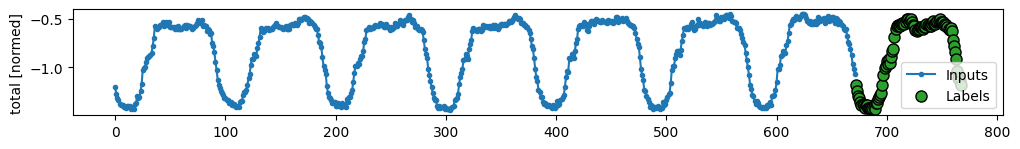

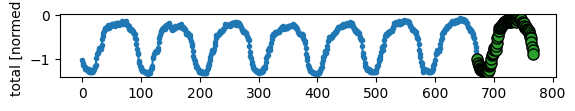

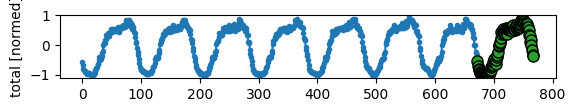

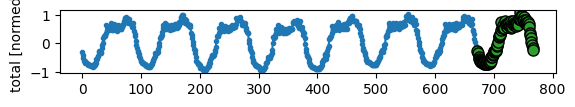

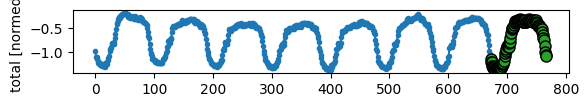

In [30]:
window.plot(None, None, plot_col='total', max_subplots=5)

In [63]:
train_u = list(window.train.unbatch().as_numpy_iterator())
val_u = list(window.val.unbatch().as_numpy_iterator())
test_u = list(window.test.unbatch().as_numpy_iterator())
X_train = [x[0][:, 0] for x in train_u]
y_train = [x[1][:, 0] for x in train_u]
X_val = [x[0][:, 0] for x in val_u]
y_val = [x[1][:, 0] for x in val_u]
X_test = [x[0][:, 0] for x in test_u]
y_test = [x[1][:, 0] for x in test_u]

In [64]:
len(X_train)

1015

In [65]:
print(len(y_train), y_train[0].shape)
print(len(X_train), X_train[0].shape)

1015 (96,)
1015 (672,)


In [66]:
def plot_window(X_train, y_train, reg=None):
    inputs = X_train[0:5]
    labels = y_train[0:5]
    plt.figure(figsize=(18, 12))
    max_n = min(5, len(inputs))
    for n in range(max_n):
        plt.subplot(max_n, 1, n + 1)
        plt.ylabel('Total [normed]')
        label_index_start = inputs[n].shape[0]
        plt.plot(range(label_index_start), inputs[n],
                    label='Inputs', marker='.', zorder=-10)

        plt.scatter(range(label_index_start, label_index_start + 96), labels[n],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
        if reg is not None:
            predictions = reg.predict(inputs)
            plt.scatter(range(label_index_start, label_index_start + 96), predictions[n],
                        marker='X', edgecolors='k', label='Predictions',
                        c='#ff7f0e', s=64)

        if n == 0:
            plt.legend()
        plt.show()

    # plt.xlabel('Time [h]')

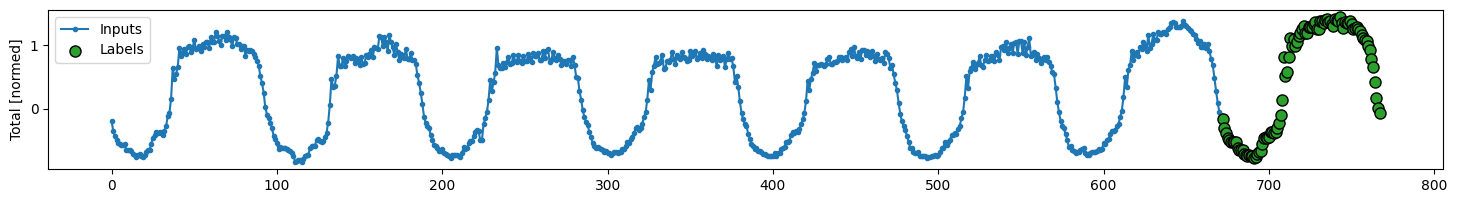

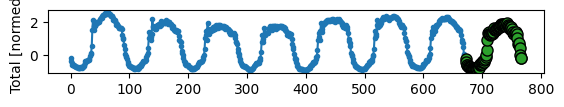

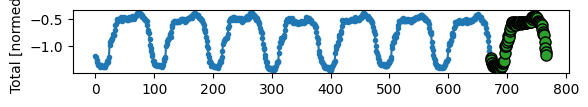

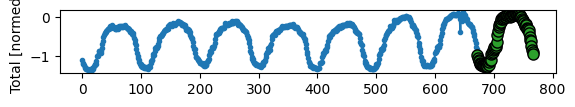

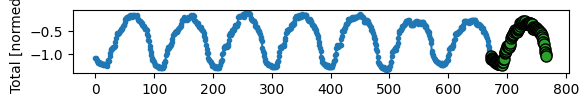

In [67]:
plot_window(X_train, y_train)

In [73]:

reg = xgb.XGBRegressor(n_estimators=20, max_depth=3, eval_metric='mae', early_stopping_rounds=10,)
reg.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_val, y_val)],        
        verbose=True)


[0]	validation_0-mae:0.58420	validation_1-mae:0.55915
[1]	validation_0-mae:0.41277	validation_1-mae:0.40277
[2]	validation_0-mae:0.29277	validation_1-mae:0.29461
[3]	validation_0-mae:0.20975	validation_1-mae:0.22119
[4]	validation_0-mae:0.15315	validation_1-mae:0.17156
[5]	validation_0-mae:0.11573	validation_1-mae:0.13943
[6]	validation_0-mae:0.09168	validation_1-mae:0.12004
[7]	validation_0-mae:0.07658	validation_1-mae:0.10881
[8]	validation_0-mae:0.06725	validation_1-mae:0.10288
[9]	validation_0-mae:0.06144	validation_1-mae:0.09951
[10]	validation_0-mae:0.05780	validation_1-mae:0.09760
[11]	validation_0-mae:0.05530	validation_1-mae:0.09661
[12]	validation_0-mae:0.05346	validation_1-mae:0.09614
[13]	validation_0-mae:0.05201	validation_1-mae:0.09601
[14]	validation_0-mae:0.05081	validation_1-mae:0.09570
[15]	validation_0-mae:0.04981	validation_1-mae:0.09551
[16]	validation_0-mae:0.04898	validation_1-mae:0.09548
[17]	validation_0-mae:0.04816	validation_1-mae:0.09545
[18]	validation_0-ma

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=10,
             enable_categorical=False, eval_metric='mae', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=20, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

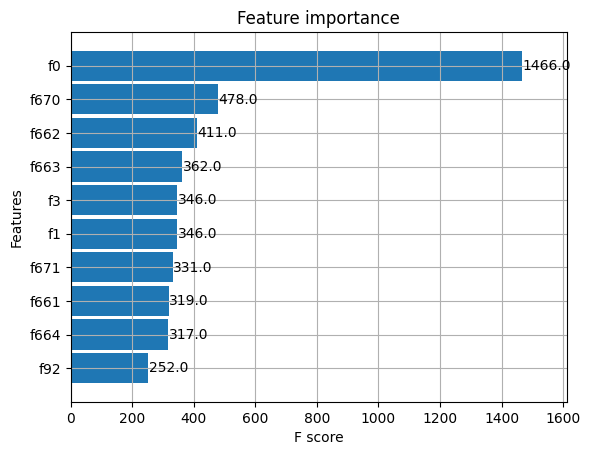

In [58]:
_ = plot_importance(reg, height=0.9, max_num_features=10)


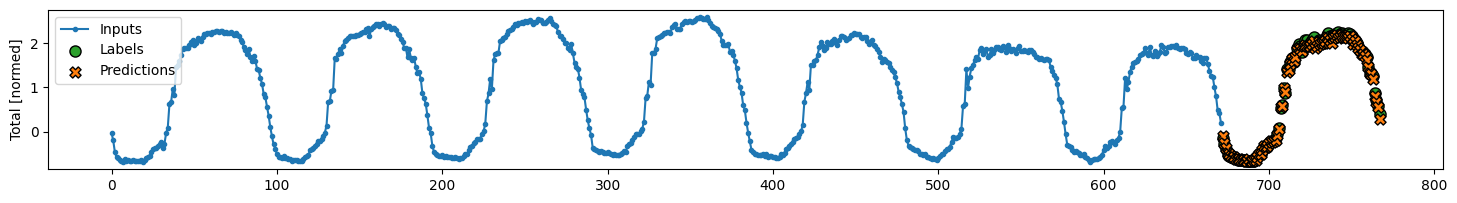

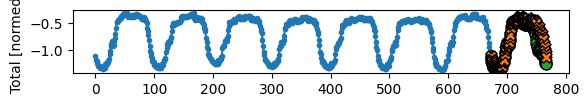

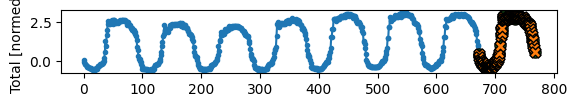

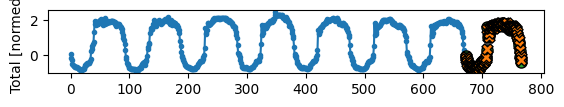

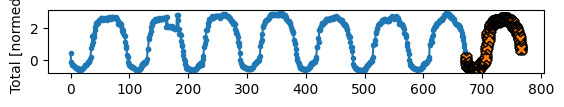

In [59]:
plot_window(X_train, y_train, reg)

In [74]:
train_pred = reg.predict(X_train)
val_pred = reg.predict(X_val) 
test_pred = reg.predict(X_test) 

In [75]:
mean_absolute_error(y_true=y_train, y_pred=train_pred)

0.046650603

In [77]:
mean_absolute_error(y_true=y_val, y_pred=val_pred)

0.09819315

In [81]:
mean_absolute_error(y_true=y_test, y_pred=test_pred)

0.113538556